In [1]:
import numpy as np
import scipy.sparse.linalg

import utils

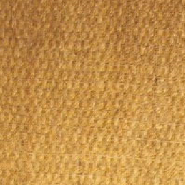

In [2]:
folder_path = "img/"

source = utils.open_and_print_image(folder_path + "tiling")

In [3]:
height, width, channels = source.shape

# create a full mask
mask = np.ones((height, width))
# create a boundary mask
boundary_mask = np.ones((height, width))
boundary_mask[np.ix_(np.arange(1, height - 1), np.arange(1, width - 1))] = 0
# create an inner mask
inner_mask = mask - boundary_mask

pixel_ids, inner_ids, boundary_ids, mask_ids = utils.get_ids(mask, inner_mask, boundary_mask)

inner_pos, boundary_pos, mask_pos = utils.get_pos(mask_ids, inner_ids, boundary_ids, pixel_ids)

In [4]:
A = utils.create_matrix_A(mask_ids, inner_ids, boundary_ids, inner_pos, boundary_pos, width)  

In [5]:
def poisson_tile_channel(src):
    gradients = utils.compute_laplacian(src)

    # mix the boundary pixels
    new_boundary = np.zeros_like(src)
    new_boundary[0] = (src[0] + src[-1]) * 0.5
    new_boundary[-1] = (src[0] + src[-1]) * 0.5
    new_boundary[:, 0] = (src[:, 0] + src[:, -1]) * 0.5
    new_boundary[:, -1] = (src[:, 0] + src[:, -1]) * 0.5

    boundary_pixel_values = utils.get_masked_values(new_boundary, boundary_mask).flatten()
    inner_gradient_values = utils.get_masked_values(gradients, inner_mask).flatten()

    # Construct b
    b = utils.construct_b(mask_ids, inner_pos, boundary_pos, inner_gradient_values, boundary_pixel_values)

    # Solve Ax = b
    x = scipy.sparse.linalg.spsolve(A, b)
    
    # reconstruct the new image (single channel)
    new_src = np.clip(src.copy(), 0, 1)
    new_src.flat[mask_pos] = x
    
    return new_src

In [6]:
def poisson_tile():
    return np.dstack([poisson_tile_channel(source[..., i]) for i in range(channels)])

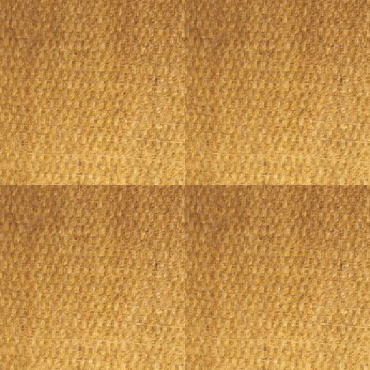

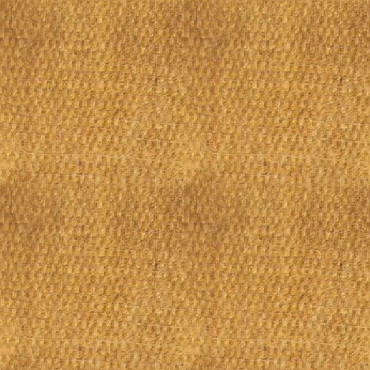

In [7]:
def tile(src, x_repeat, y_repeat):
    return np.tile(src, (y_repeat, x_repeat, 1))

img = poisson_tile()

orig_tile = tile(source, 2, 2)
new_tile = tile(img, 2, 2)

utils.save_and_print(orig_tile, folder_path, "orig_tile.png")

utils.save_and_print(new_tile, folder_path, "new_tile.png")